In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")

plot_font_size = 18

In [2]:
dataset_file = "./RFLFSODataFull.csv"
data = pd.read_csv(dataset_file)

In [3]:
data.head()

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,7.913289,6.927868,17.595709,17.615907,17.340148,2115.338398,83500000000,0.0,0.0,0.0,...,26.603030,24.680849,9,65884.51846,72336.362233,65617.543754,88.755450,3.057066,6.863808,3.007939
1,7.451176,4.412096,17.549693,17.572415,17.299439,2113.999257,73500000000,0.0,0.0,0.0,...,26.377164,24.313108,9,64963.41092,68753.386153,60379.327485,99.790057,2.727910,6.468903,2.537393
2,7.072747,6.268740,17.290230,17.644014,16.037894,2118.689047,83500000000,0.0,0.0,0.0,...,27.670822,23.150277,10,54794.28107,54821.773817,50850.155963,65.730085,1.674810,2.826916,1.640809
3,6.949288,4.317853,16.820880,17.066776,15.895622,2114.632339,73500000000,0.0,0.0,0.0,...,26.522100,23.174815,10,50205.64159,52519.927530,45374.510898,88.127497,0.962068,2.780643,0.886951
4,7.361052,6.114514,16.813820,17.953974,15.227225,2116.786055,83500000000,0.0,0.0,0.0,...,26.305736,24.864100,10,59038.32599,64418.329138,54461.246506,84.167414,1.881007,4.476298,1.874052


# Util for method 2 and 3

In [4]:
data.columns

Index(['FSO_Att', 'RFL_Att', 'AbsoluteHumidity', 'AbsoluteHumidityMax',
       'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate',
       'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax',
       'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature',
       'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time',
       'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindDirection',
       'WindSpeed', 'WindSpeedMax', 'WindSpeedMin'],
      dtype='object')

In [5]:
def train_and_predict(df, target_cols, random_state):
    train_df, test_df_original = train_test_split(df, test_size=0.3, random_state=random_state)
    test_df_predicted = test_df_original.copy()

    models = {}

    target1, target2 = target_cols

    # Step 1: Train Model 1 to predict target1 (d)
    print(f"\nTraining Model 1 to predict: {target1}")
    rf_model1 = RandomForestRegressor(
        n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,
        random_state=random_state, n_jobs=-1
    )

    # Use features + target2 (but not target1)
    X_train1 = train_df.drop(columns=[target1])
    y_train1 = train_df[target1]

    rf_model1.fit(X_train1, y_train1)
    models[target1] = rf_model1

    # Predict target1 on test set
    X_test1 = test_df_original.drop(columns=[target1])
    test_df_predicted[target1] = rf_model1.predict(X_test1)

    # Step 2: Train Model 2 to predict target2 (e) using target1'
    print(f"\nTraining Model 2 to predict: {target2}, using {target1}' as input")

    rf_model2 = RandomForestRegressor(
        n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,
        random_state=random_state, n_jobs=-1
    )

    # Use features + target1' (but not target2)
    X_train2 = train_df.drop(columns=[target2]).copy()
    X_train2[target1] = rf_model1.predict(X_train1)  # Replace target1 with predicted values

    y_train2 = train_df[target2]

    rf_model2.fit(X_train2, y_train2)
    models[target2] = rf_model2

    # Predict target2 using target1' in test data
    X_test2 = test_df_predicted.drop(columns=[target2]).copy()
    test_df_predicted[target2] = rf_model2.predict(X_test2)

    return test_df_original, test_df_predicted, models


def evaluate_model(actual_df, predicted_df, target_col):
    if target_col not in actual_df.columns or target_col not in predicted_df.columns:
        print(f"Warning: Target column '{target_col}' not found in one or both DataFrames.")
        return

    y_actual = actual_df[target_col].values
    y_pred = predicted_df[target_col].values

    if len(y_actual) != len(y_pred):
        print(f"Error: Length mismatch in evaluate_model for {target_col}. Actual: {len(y_actual)}, Predicted: {len(y_pred)}")
        return

    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    r2 = r2_score(y_actual, y_pred)

    print(f"\nEvaluation for {target_col} (on Test Set):")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - R² Score: {r2:.4f}")


In [6]:
random_state = 42

print("--- Method 2 ---")
target_cols_m2 = ["RFL_Att", "FSO_Att"]
original_test_df_m2, predicted_test_df_m2, models_m2 = train_and_predict(data, target_cols=target_cols_m2, random_state=random_state)

# Evaluate Method 2 for each target on the test set
evaluate_model(original_test_df_m2, predicted_test_df_m2, target_col="FSO_Att")


print("\n--- Method 3 ---")
target_cols_m3 = ["FSO_Att", "RFL_Att"]
original_test_df_m3, predicted_test_df_m3, models_m3 = train_and_predict(data, target_cols=target_cols_m3, random_state=random_state)

# Evaluate Method 3 for each target on the test set
evaluate_model(original_test_df_m3, predicted_test_df_m3, target_col="RFL_Att")

--- Method 2 ---

Training Model 1 to predict: RFL_Att

Training Model 2 to predict: FSO_Att, using RFL_Att' as input

Evaluation for FSO_Att (on Test Set):
  - RMSE: 1.1718
  - R² Score: 0.9083

--- Method 3 ---

Training Model 1 to predict: FSO_Att

Training Model 2 to predict: RFL_Att, using FSO_Att' as input

Evaluation for RFL_Att (on Test Set):
  - RMSE: 0.6574
  - R² Score: 0.9632


In [40]:
def calculate_mutual_information(df, x_col, y_col, bins=50):
    # Step 1: Discretize the continuous data into bins
    x_binned = pd.cut(df[x_col], bins=bins, labels=False)
    y_binned = pd.cut(df[y_col], bins=bins, labels=False)

    # Step 2: Create joint probability matrix
    joint_counts = pd.crosstab(x_binned, y_binned)
    joint_prob = joint_counts / joint_counts.values.sum()

    # Step 3: Marginal probabilities
    p_x = joint_prob.sum(axis=1)
    p_y = joint_prob.sum(axis=0)

    # Step 4: Compute entropies
    def entropy(p):
        p_nonzero = p[p > 0]
        return -np.sum(p_nonzero * np.log2(p_nonzero))

    H_X = entropy(p_x)
    H_Y = entropy(p_y)
    H_XY = entropy(joint_prob.values.flatten())

    # Step 5: Mutual Information
    MI = H_X + H_Y - H_XY

    print("\n--- Mutual Information Results ---")
    print(f"H(RFL_Att): {H_X:.4f}")
    print(f"H(FSO_Att): {H_Y:.4f}")
    print(f"H(RFL_Att, FSO_Att): {H_XY:.4f}")
    print(f"Mutual Information I(RFL_Att ; FSO_Att): {MI:.4f}")

    return MI, joint_prob

mi_value, joint_prob = calculate_mutual_information(data, x_col="RFL_Att", y_col="FSO_Att")


--- Mutual Information Results ---
H(RFL_Att): 3.5063
H(FSO_Att): 4.3318
H(RFL_Att, FSO_Att): 7.4470
Mutual Information I(RFL_Att ; FSO_Att): 0.3911


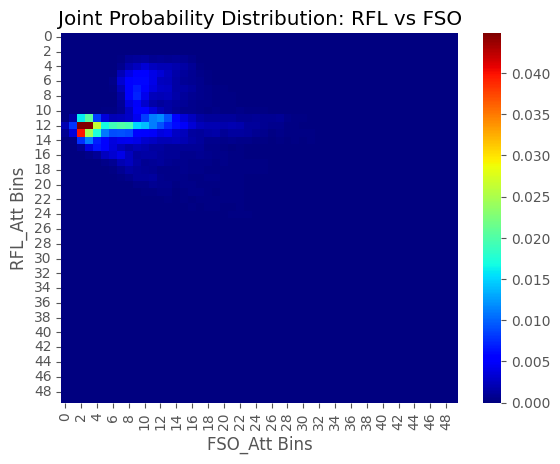

In [41]:
sns.heatmap(joint_prob, cmap="jet")
plt.title("Joint Probability Distribution: RFL vs FSO")
plt.xlabel("FSO_Att Bins")
plt.ylabel("RFL_Att Bins")
plt.show()

In [42]:
# Map SYNOP codes to weather types
synop_labels = {
    0: 'clear',
    3: 'dust storm',
    4: 'fog',
    5: 'drizzle',
    6: 'rain',
    7: 'snow',
    8: 'showers'
}

# Combine test sets with original and predicted values
combined_df = original_test_df_m2[['SYNOPCode', 'RFL_Att', 'FSO_Att']].copy()
combined_df['RFL_Att_pred'] = predicted_test_df_m3['RFL_Att'].values
combined_df['FSO_Att_pred'] = predicted_test_df_m2['FSO_Att'].values

# Function to calculate normalized mutual information
def calculate_normalized_mutual_information(x, y, bins=10):
    c_xy = np.histogram2d(x, y, bins)[0]
    pxy = c_xy / np.sum(c_xy)

    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)

    H_x = -np.sum(px[px > 0] * np.log2(px[px > 0]))
    H_y = -np.sum(py[py > 0] * np.log2(py[py > 0]))
    H_xy = -np.sum(pxy[pxy > 0] * np.log2(pxy[pxy > 0]))

    mutual_info = H_x + H_y - H_xy

    return mutual_info / H_xy if H_xy > 0 else np.nan

# Compute correlation values per SYNOPCode
results = {'SYNOPCode': [], 'r_EO': [], 'I_EO_H_EO': []}

for code in combined_df['SYNOPCode'].unique():
    sub_df = combined_df[combined_df['SYNOPCode'] == code]

    try:
        r_measured, _ = pearsonr(sub_df['RFL_Att'], sub_df['FSO_Att'])
    except:
        r_measured = np.nan

    try:
        norm_mi = calculate_normalized_mutual_information(
            sub_df['RFL_Att_pred'], sub_df['FSO_Att_pred'], bins=10
        )
    except:
        norm_mi = np.nan

    results['SYNOPCode'].append(code)
    results['r_EO'].append(r_measured)
    results['I_EO_H_EO'].append(norm_mi)

corr_df = pd.DataFrame(results)
corr_df.sort_values('SYNOPCode', inplace=True)

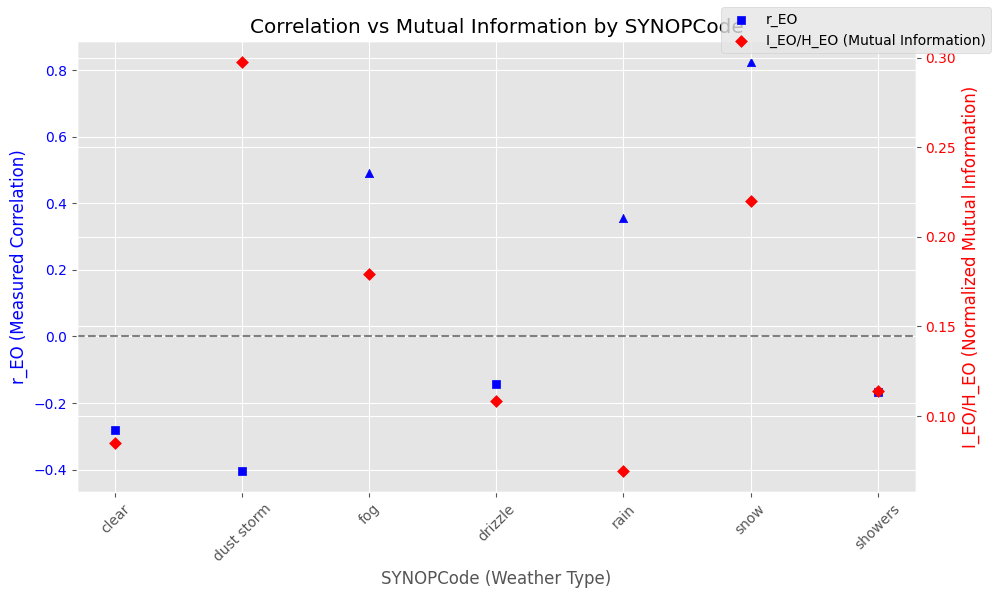

In [43]:
# Create a new column for categorical x positions
corr_df['CategoryIndex'] = range(len(corr_df))

# Plotting with corrected x-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left y-axis for r_EO
for idx, row in corr_df.iterrows():
    marker = '^' if row['r_EO'] >= 0 else 's'
    ax1.scatter(row['CategoryIndex'], row['r_EO'], color='blue', marker=marker, label='r_EO' if idx == 0 else "")

ax1.set_xlabel('SYNOPCode (Weather Type)')
ax1.set_xticks(corr_df['CategoryIndex'])
ax1.set_xticklabels([synop_labels.get(code, str(code)) for code in corr_df['SYNOPCode']], rotation=45)
ax1.set_ylabel('r_EO (Measured Correlation)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.axhline(0, color='gray', linestyle='--')

# Right y-axis for I_EO/H_EO (Mutual Information)
ax2 = ax1.twinx()
ax2.scatter(corr_df['CategoryIndex'], corr_df['I_EO_H_EO'], color='red', marker='D', label='I_EO/H_EO (Mutual Information)')
ax2.set_ylabel('I_EO/H_EO (Normalized Mutual Information)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.title('Correlation vs Mutual Information by SYNOPCode')
plt.tight_layout()
plt.show()
